In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [ ]:
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

In [ ]:
# Neural Network Parameters
batch_size, n_epoc = 100, 50
n_hidden, z_dim = 256, 2

In [ ]:
# Example of a training image
plt.imshow(x_tr[1])

In [ ]:
# Sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [ ]:
# Encoder = from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat) # second hidden layer

# Hidden state, which we will pass into the model to get the encoder
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [ ]:
# Decoder = from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")
outputs_flat = decoder_flat(z_flat)

In [ ]:
# Variational Autoencoder (VAE) - to reconstruct the input
# I'm not sure if this is a version issue, but the code from the example gives me an error
reconstruction_loss = losses.binary_crossentropy(inputs_flat, outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis=-1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model, ensuring that the reconstructed outputs are as close to the inputs as possible
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [ ]:
# Train
vae_flat.fit(x_tr_flat, shuffle=True, epochs=n_epoc, batch_size=batch_size, validation_data=(x_te_flat, None), verbose=1)


In [ ]:
# Build encoders
encoder_f = Model(inputs_flat, mu_flat)

In [ ]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size, verbose=0)
plt.figure(figsize=(8,6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:1, 1], c=y_te, alpha=0.75)
plt.title("MNIST 2D Embeedings")
plt.colorbar()
plt.show()

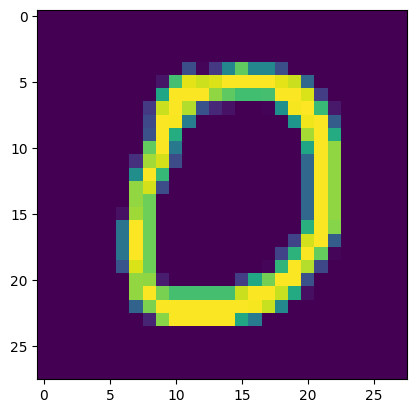

In [21]:
plt.imshow(x_te_flat[10].reshape(28, 28))


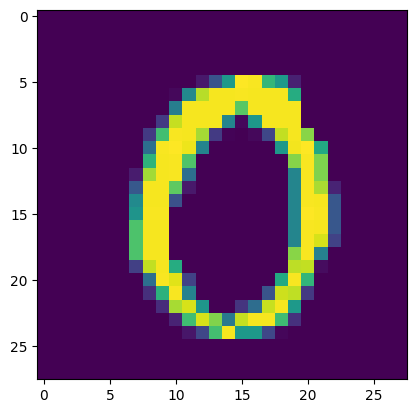

In [22]:
plt.imshow(x_te_flat[13].reshape(28,28))

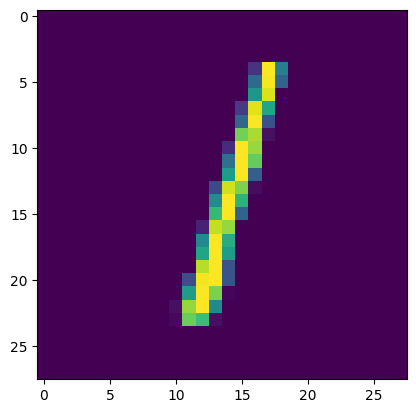

In [23]:
plt.imshow(x_te_flat[2].reshape(28,28))

In [33]:
# Calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is {one}")

NameError: name 'x_te_latent' is not defined

In [24]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

c:\Users\RKeelan\Src\DeepLearningAi\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [26]:
embedding = model.encode(sentence)
print(embedding)

[[ 0.3706196   0.26414248  0.21265674 ...  0.14994545 -0.2579491
  -0.23970762]
 [ 0.6693329   0.40094966 -0.48208374 ...  0.10645895 -1.5067163
  -0.01547347]
 [-0.26555917  0.1117238  -0.1473302  ...  0.4219747   0.883946
   0.10763928]]


In [27]:
embedding.shape

(3, 384)

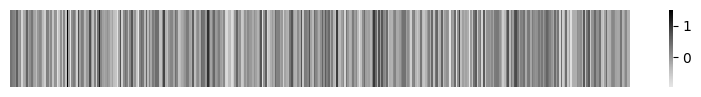

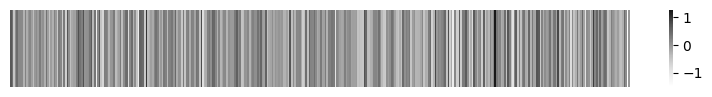

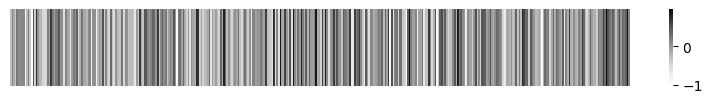

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(embedding[0].reshape(-1,384), cmap="Greys", center=0, square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384), cmap="Greys", center=0, square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384), cmap="Greys", center=0, square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()


In [32]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

np.linalg.norm((zero_A - zero_B), ord=2)

# Calculate L2 distances
print("Distance zeroA-zeroB", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one", np.linalg.norm((zero_B - one), ord=2))

NameError: name 'zero_A' is not defined

In [ ]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()
print(L1)

np.linalg.norm((zero_A - zero_B), ord=1)
# Calculate L1 distances
print("Distance zeroA-zeroB", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one", np.linalg.norm((zero_B - one), ord=1))

In [ ]:
# Dot Product
np.dot(zero_A, zero_B)
print("Distance zeroA-zeroB", np.dot(zero_A, zero_B))
print("Distance zeroA-one", np.dot(zero_A, one))
print("Distance zeroB-one", np.dot(zero_B, one))

In [ ]:
# Cosine Distance
cosine = 1 - np.dot(zero_A, zero_B) / (np.linalg.norm(zero_A) * np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

In [ ]:
zero_A/zero_B

In [34]:
# Cosine Distance function
def cosine_distance(vec1, vec2):
    cosine = 1 - (np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
    return cosine

In [ ]:
print("Distance zeroA-zeroB", cosine_distance(zero_A, zero_B))
print("Distance zeroA-one", cosine_distance(zero_A, one))
print("Distance zeroB-one", cosine_distance(zero_B, one))

In [35]:
# Now, with sentence embeddings
# Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497894
Distance 0-2: 2.0785723
Distance 1-2: 4.019208


In [36]:
# Cosine Distance
print("Distance 0-1:", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2:", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2:", cosine_distance(embedding[1], embedding[2]))

Distance 0-1: 0.5350335538387299
Distance 0-2: 0.963939405977726
Distance 1-2: 0.9288791641592979
